In [ ]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_excel('DATA SKRIPSI forecast.xlsx', sheet_name='Forecast')
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Produksi_X1'] = df['Produksi_X1'].round()
df['Produksi_X2'] = df['Produksi_X2'].round()
df.head()

,Tanggal,Produksi_X1,Produksi_X2
0,2021-08-16,5238.0,4445.0
1,2021-08-17,5203.0,3960.0
2,2021-08-18,4893.0,3351.0
3,2021-08-19,5203.0,3960.0
4,2021-08-20,5477.0,4083.0


# Beras X1

## FB Prophet

In [ ]:
x1 = df[['Tanggal','Produksi_X1']]
x1 = x1.rename(columns={'Tanggal':'ds', 'Produksi_X1':'y'})
x1.tail()

,ds,y
137,2022-01-26,3062.0
138,2022-01-27,5378.0
139,2022-01-28,3288.0
140,2022-01-29,3834.0
141,2022-01-31,5336.0


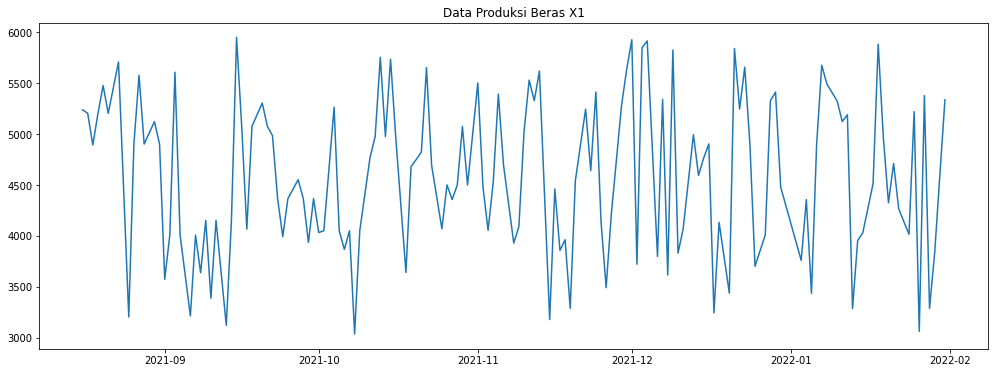

In [ ]:
plt.figure(figsize=(17,6))
plt.plot(x1['ds'], x1['y'])
plt.title('Data Produksi Beras X1')
plt.show()

In [ ]:
adfuller_x1 = adfuller(x1['y'])

print('p-value: {}'.format(adfuller_x1[1]))
print('test stat: {} '.format(adfuller_x1[0]))
print('critical value: {} '.format(adfuller_x1[4]))

print('data stationer')

p-value: 6.990174791545214e-18
test stat: -10.173481725754435 
critical value: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156} 
data stationer


In [ ]:
cut_x1 = pd.to_datetime('2021-12-31')
train_x1 = x1[x1['ds'] < cut_x1]
test_x1 = x1[x1['ds'] >= cut_x1]

In [ ]:
train_x1.tail()

,ds,y
112,2021-12-25,3701.0
113,2021-12-27,4009.0
114,2021-12-28,5328.0
115,2021-12-29,5412.0
116,2021-12-30,4479.0


In [ ]:
test_x1.head()

,ds,y
117,2022-01-03,3759.0
118,2022-01-04,4356.0
119,2022-01-05,3436.0
120,2022-01-06,4893.0
121,2022-01-07,5676.0


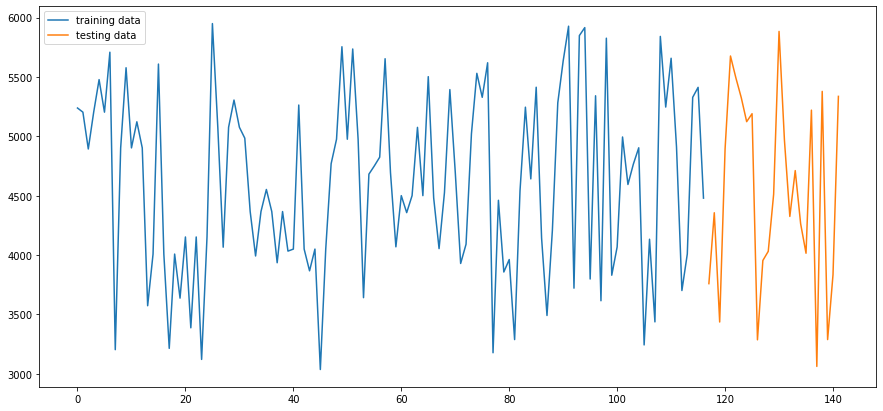

In [ ]:
fig,ax = plt.subplots(figsize=(15,7))
train_x1['y'].plot(ax=ax, label='training data')
test_x1['y'].plot(ax=ax, label='testing data')
plt.legend()
plt.show()

In [ ]:
model_1 = Prophet(changepoint_prior_scale=0.01)
model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_1.fit(train_x1)

pred_1 = model_1.predict(test_x1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_1 = model_1.make_future_dataframe(periods = 365, freq = 'D') #202 data (test size)
forecast_1 = model_1.predict(future_1)

plot_plotly(model_1, forecast_1)

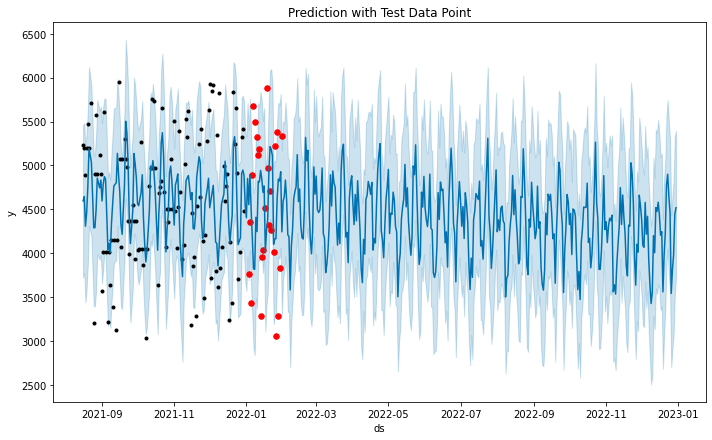

In [ ]:
rol_mean_x1 = forecast_1['yhat'].rolling(window=180).mean()

fig = model_1.plot(forecast_1)
plt.scatter(x=test_x1['ds'], y=test_x1['y'], s=30, color='red')
plt.grid(False)
plt.title('Prediction with Test Data Point')
plt.show()

In [ ]:
plot_components_plotly(model_1, forecast_1)

In [ ]:
from fbprophet.diagnostics import cross_validation

cv_1 = cross_validation(model_1, horizon='30 days')
cv_1.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-11-15 00:00:00 and 2021-11-30 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-11-16,4745.868620,3992.127996,5532.554048,4461.0,2021-11-15
1,2021-11-17,4589.869209,3813.411483,5356.648235,3857.0,2021-11-15
2,2021-11-18,4820.081594,4133.424667,5604.591763,3962.0,2021-11-15
3,2021-11-19,5159.360906,4394.394864,5878.469666,3288.0,2021-11-15
4,2021-11-20,5239.075967,4457.587901,6009.829164,4541.0,2021-11-15


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p_1 = performance_metrics(cv_1)
df_p_1.tail(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
18,21 days,7.871018e+05,887.187554,801.159377,0.170531,0.176992,0.5
19,22 days,8.889432e+05,942.837841,789.048424,0.173158,0.140283,0.6
20,23 days,6.405592e+05,800.349425,584.723615,0.109085,0.072507,0.8
21,24 days,1.025044e+06,1012.444804,739.605885,0.132626,0.117523,0.7
22,25 days,8.662641e+05,930.733107,720.279740,0.146509,0.117239,0.8
23,26 days,8.983560e+05,947.816457,776.760888,0.164967,0.151828,0.8
24,27 days,5.606522e+05,748.767120,606.743898,0.138396,0.117239,0.9
25,28 days,2.318961e+05,481.555908,431.049574,0.099737,0.118047,1.0
26,29 days,2.071311e+05,455.116598,403.924166,0.080911,0.081129,1.0
27,30 days,1.675889e+05,409.376237,343.867126,0.068597,0.054342,1.0


## ARIMA

In [ ]:
x1_sarima = x1.copy().set_index('ds')
x1_sarima['y'] = x1_sarima['y']
x1_sarima

,y
ds,
2021-08-16,5238.0
2021-08-17,5203.0
2021-08-18,4893.0
2021-08-19,5203.0
2021-08-20,5477.0
...,...
2022-01-26,3062.0
2022-01-27,5378.0
2022-01-28,3288.0


In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

sarimax = sm.tsa.statespace.SARIMAX

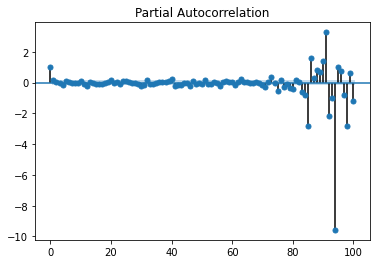

In [ ]:
plot_pacf(x1_sarima['y'], lags=100);

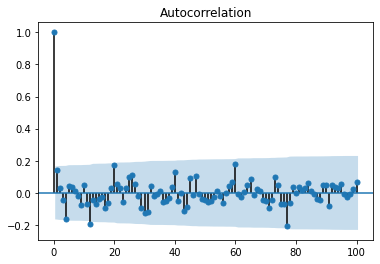

In [ ]:
plot_acf(x1_sarima['y'], lags=100);

In [ ]:
cut_sarima_x1 = pd.to_datetime('2022-01-01')
train_sarima_x1 = x1_sarima[x1_sarima.index < cut_sarima_x1]
test_sarima_x1 = x1_sarima[x1_sarima.index >= cut_sarima_x1]

In [ ]:
model_sarima_x1 = sarimax(train_sarima_x1, order=(20,0,20))
result_sarima_x1 = model_sarima_x1.fit()

In [ ]:
pred_sarima_x1 = result_sarima_x1.predict(len(train_sarima_x1), len(train_sarima_x1) + 365)
pred_index = pd.date_range(start='2022-01-03', end='2023-01-03')
prediction_sarima_x1 = pd.DataFrame(index=pred_index, data=pred_sarima_x1.values)
prediction_sarima_x1 = prediction_sarima_x1.rename(columns={0:'Prediction_SARIMA_X1'})
prediction_sarima_x1.head()

,Prediction_SARIMA_X1
2022-01-03,4557.979065
2022-01-04,5745.122330
2022-01-05,4636.955712
2022-01-06,4493.146323
2022-01-07,3920.094642


In [ ]:
trend_sarima_x1 = prediction_sarima_x1.rolling(window=60).mean()
trend_sarima_x1 = trend_sarima_x1.rename(columns={'Prediction_SARIMA_X1':'Trend_SARIMA_X1'})
trend_sarima_x1.head()

,Trend_SARIMA_X1
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN


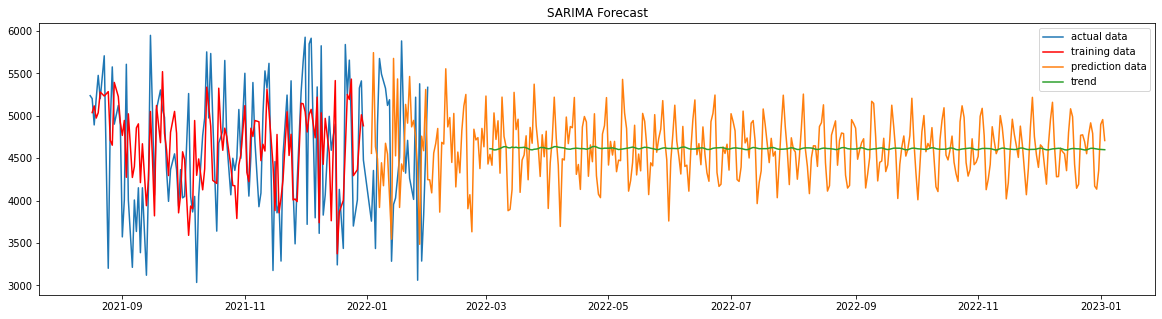

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(x1_sarima['y'], label = 'actual data')
plt.plot(result_sarima_x1.fittedvalues.drop('2021-08-16'), c='red', label='training data')
plt.plot(prediction_sarima_x1, label='prediction data')
plt.plot(trend_sarima_x1, label='trend')

plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
rmse_sarima_x1 = test_sarima_x1.merge(prediction_sarima_x1, how='left', left_index=True, right_index=True)

print('Test Data RMSE SARIMA X1: {}'.format(np.sqrt(mean_squared_error(rmse_sarima_x1['y'], rmse_sarima_x1['Prediction_SARIMA_X1']))))
print('Test Data MAPE SARIMA X1: {}'.format(mean_absolute_percentage_error(rmse_sarima_x1['y'], rmse_sarima_x1['Prediction_SARIMA_X1'])))

print(f'{len(rmse_sarima_x1)} hari')

Test Data RMSE SARIMA X1: 1076.205696550764
Test Data MAPE SARIMA X1: 0.2206943275479854
25 hari


# Beras X2

## FB Prophet

In [ ]:
x2 = df[['Tanggal','Produksi_X2']]
x2 = x2.rename(columns={'Tanggal':'ds', 'Produksi_X2':'y'})
x2.tail()

,ds,y
137,2022-01-26,5426.0
138,2022-01-27,5769.0
139,2022-01-28,4112.0
140,2022-01-29,4824.0
141,2022-01-31,3551.0


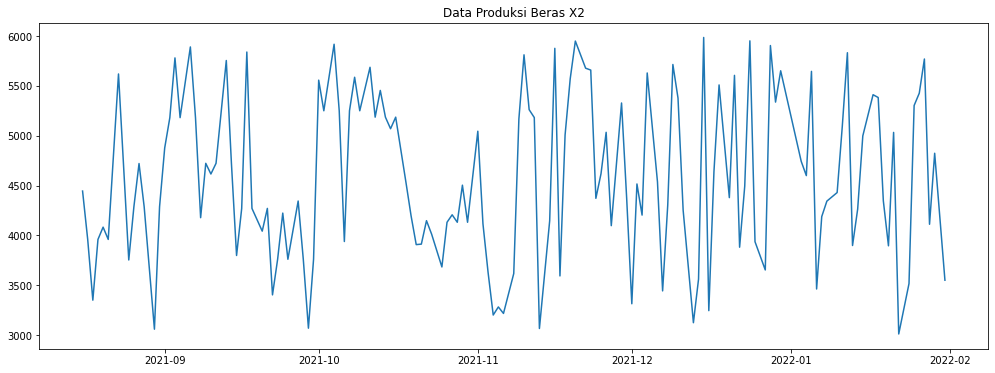

In [ ]:
plt.figure(figsize=(17,6))
plt.plot(x2['ds'], x2['y'])
plt.title('Data Produksi Beras X2')
plt.show()

In [ ]:
adfuller_x2 = adfuller(x2['y'])

print('p-value: {}'.format(adfuller_x2[1]))
print('test stat: {} '.format(adfuller_x2[0]))
print('critical value: {} '.format(adfuller_x2[4]))

print('data stationer')

p-value: 0.00017741213398243826
test stat: -4.524670253084814 
critical value: {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623} 
data stationer


In [ ]:
cut_x2 = pd.to_datetime('2021-12-31')
train_x2 = x2[x2['ds'] < cut_x2]
test_x2 = x2[x2['ds'] >= cut_x2]

In [ ]:
train_x2.tail()

,ds,y
112,2021-12-25,3937.0
113,2021-12-27,3654.0
114,2021-12-28,5904.0
115,2021-12-29,5337.0
116,2021-12-30,5651.0


In [ ]:
test_x2.head()

,ds,y
117,2022-01-03,4743.0
118,2022-01-04,4600.0
119,2022-01-05,5645.0
120,2022-01-06,3463.0
121,2022-01-07,4189.0


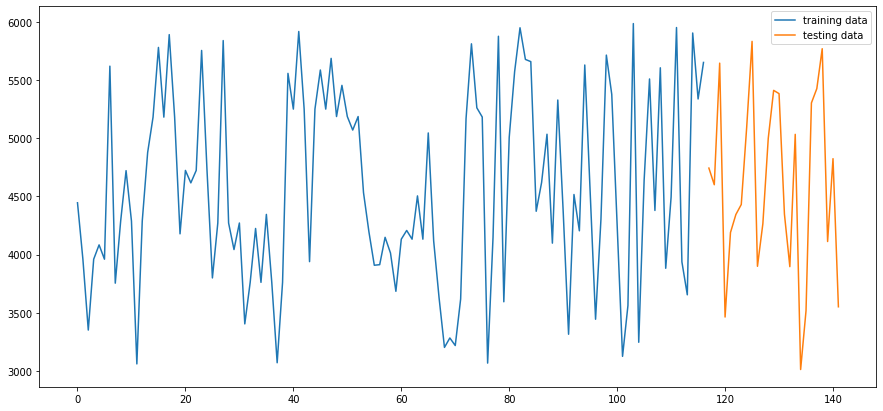

In [ ]:
fig,ax = plt.subplots(figsize=(15,7))
train_x2['y'].plot(ax=ax, label='training data')
test_x2['y'].plot(ax=ax, label='testing data')
plt.legend()
plt.show()

In [ ]:
model_2 = Prophet(changepoint_prior_scale=0.1)
model_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_2.fit(train_x2)

pred_2 = model_2.predict(test_x2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_2 = model_2.make_future_dataframe(periods = 365, freq = 'D') #202 data (test size)
forecast_2 = model_2.predict(future_2)

plot_plotly(model_2, forecast_2)

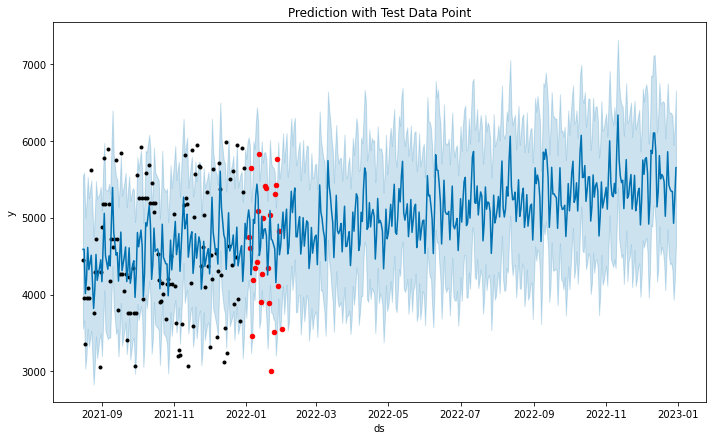

In [ ]:
fig = model_2.plot(forecast_2)
plt.scatter(x=test_x2['ds'], y=test_x2['y'], s=20, color='red')
plt.grid(False)
plt.title('Prediction with Test Data Point')
plt.show()

In [ ]:
plot_components_plotly(model_2, forecast_2)

In [ ]:
from fbprophet.diagnostics import cross_validation

cv_2 = cross_validation(model_2, horizon='30 days')
cv_2.tail()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-11-15 00:00:00 and 2021-11-30 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
47,2021-12-25,4666.643640,3808.795725,5541.283249,3937.0,2021-11-30
48,2021-12-27,4904.563471,4018.487126,5747.786885,3654.0,2021-11-30
49,2021-12-28,4587.353980,3720.830107,5421.330259,5904.0,2021-11-30
50,2021-12-29,3937.192248,3110.827181,4795.022650,5337.0,2021-11-30
51,2021-12-30,4413.165933,3518.264913,5255.401252,5651.0,2021-11-30


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p_2 = performance_metrics(cv_2)
df_p_2.tail(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
18,21 days,1.153458e+06,1073.991833,949.630110,0.185837,0.159765,0.6
19,22 days,4.213356e+05,649.103655,578.318218,0.127441,0.122054,0.8
20,23 days,4.149153e+05,644.139225,514.607819,0.117761,0.111834,0.7
21,24 days,1.107641e+06,1052.445389,843.202499,0.164688,0.144337,0.4
22,25 days,1.237958e+06,1112.635764,993.872535,0.193028,0.185330,0.3
23,26 days,1.132613e+06,1064.242799,920.427763,0.176240,0.166523,0.4
24,27 days,1.018170e+06,1009.044317,896.644105,0.197354,0.166523,0.4
25,28 days,9.796234e+05,989.759286,910.857344,0.219366,0.223009,0.3
26,29 days,1.227202e+06,1107.791505,990.061664,0.228070,0.262284,0.2
27,30 days,2.728768e+06,1651.898199,1357.010655,0.250546,0.262284,0.2


## ARIMA

In [ ]:
x2_sarima = x2.copy().set_index('ds')
x2_sarima['y'] = x2_sarima['y']
x2_sarima

,y
ds,
2021-08-16,4445.0
2021-08-17,3960.0
2021-08-18,3351.0
2021-08-19,3960.0
2021-08-20,4083.0
...,...
2022-01-26,5426.0
2022-01-27,5769.0
2022-01-28,4112.0


In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

sarimax = sm.tsa.statespace.SARIMAX

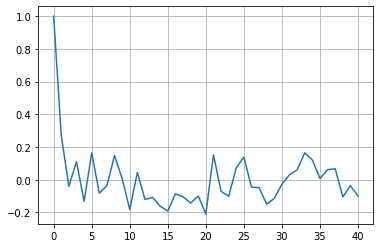

In [ ]:
plt.plot(pacf(x2_sarima['y']))
plt.grid()

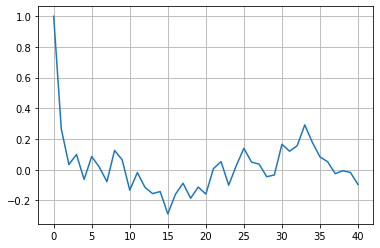

In [ ]:
plt.plot(acf(x2_sarima['y']))
plt.grid()

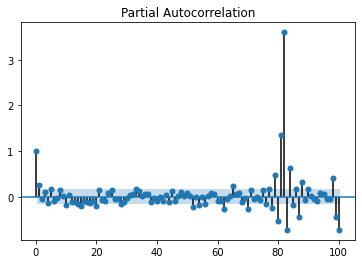

In [ ]:
plot_pacf(x2_sarima['y'], lags=100);

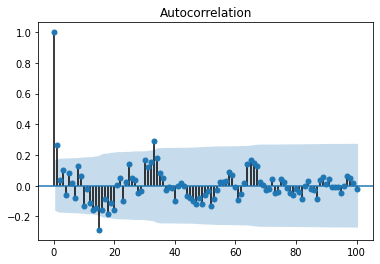

In [ ]:
plot_acf(x2_sarima['y'], lags=100);

In [ ]:
cut_sarima_x2 = pd.to_datetime('2021-12-31')
train_sarima_x2 = x2_sarima[x2_sarima.index < cut_sarima_x2]
test_sarima_x2 = x2_sarima[x2_sarima.index >= cut_sarima_x2]

In [ ]:
model_sarima_x2 = sarimax(train_sarima_x2, order=(10,0,10))
result_sarima_x2 = model_sarima_x2.fit()

In [ ]:
pred_sarima_x2 = result_sarima_x2.predict(len(train_sarima_x2), len(train_sarima_x2)+365)
pred_index = pd.date_range(start='2022-01-03', end='2023-01-03')
prediction_sarima_x2 = pd.DataFrame(index=pred_index, data=pred_sarima_x2.values)
prediction_sarima_x2 = prediction_sarima_x2.rename(columns={0:'Prediction_SARIMA_X2'})
prediction_sarima_x2

,Prediction_SARIMA_X2
2022-01-03,5071.540173
2022-01-04,3543.285938
2022-01-05,5325.970242
2022-01-06,5238.815674
2022-01-07,3908.500962
...,...
2022-12-30,3995.033893
2022-12-31,3986.677422
2023-01-01,3980.891737
2023-01-02,3977.573681


In [ ]:
trend_sarima_x2 = prediction_sarima_x2.rolling(window=60).mean()
trend_sarima_x2 = trend_sarima_x2.rename(columns={'Prediction_SARIMA_X2':'Trend_SARIMA_X2'})
trend_sarima_x2.tail()

,Trend_SARIMA_X2
2022-12-30,4055.396608
2022-12-31,4052.974755
2023-01-01,4050.521430
2023-01-02,4048.167437
2023-01-03,4046.054206


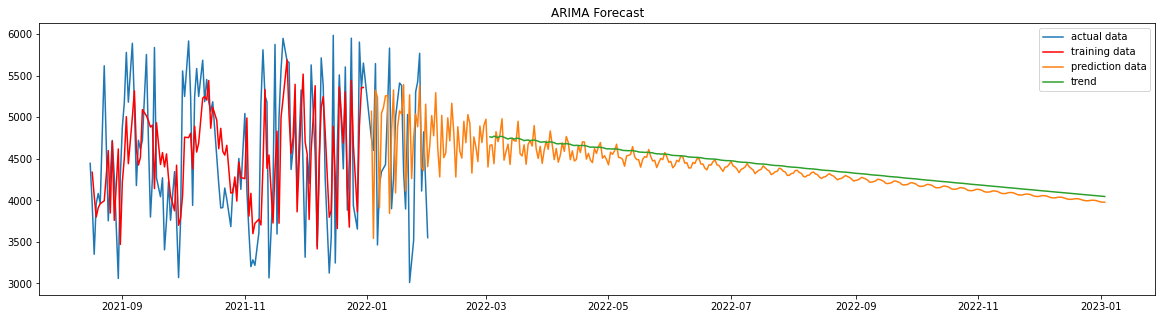

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(x2_sarima['y'], label = 'actual data')
plt.plot(result_sarima_x2.fittedvalues.drop('2021-08-16'), c='red', label='training data')
plt.plot(prediction_sarima_x2, label='prediction data')
plt.plot(trend_sarima_x2, label='trend')

plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
rmse_sarima_x2 = test_sarima_x2.merge(prediction_sarima_x2, how='left', left_index=True, right_index=True)

print('Test Data RMSE SARIMA X2: {}'.format(np.sqrt(mean_squared_error(rmse_sarima_x2['y'], rmse_sarima_x2['Prediction_SARIMA_X2']))))
print('Test Data MAPE SARIMA X2: {}'.format(mean_absolute_percentage_error(rmse_sarima_x2['y'], rmse_sarima_x2['Prediction_SARIMA_X2'])))

print(f'{len(rmse_sarima_x2)} hari')

Test Data RMSE SARIMA X2: 945.0128331292404
Test Data MAPE SARIMA X2: 0.1829048033004399
25 hari
